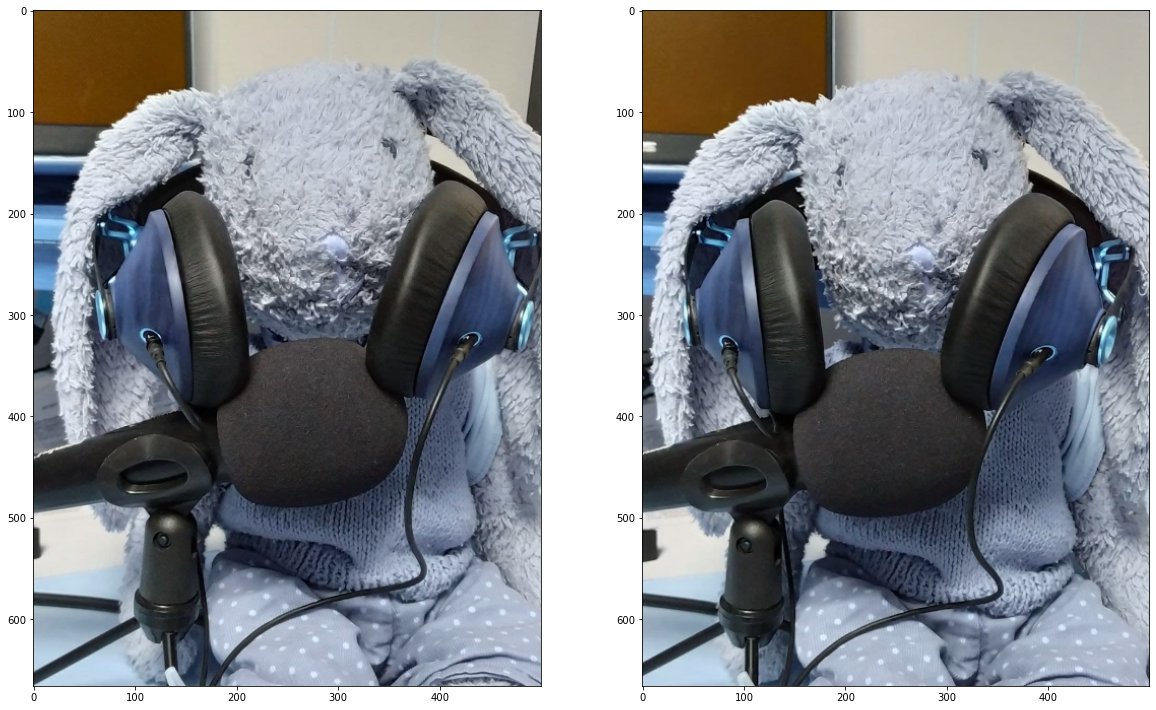

Our results


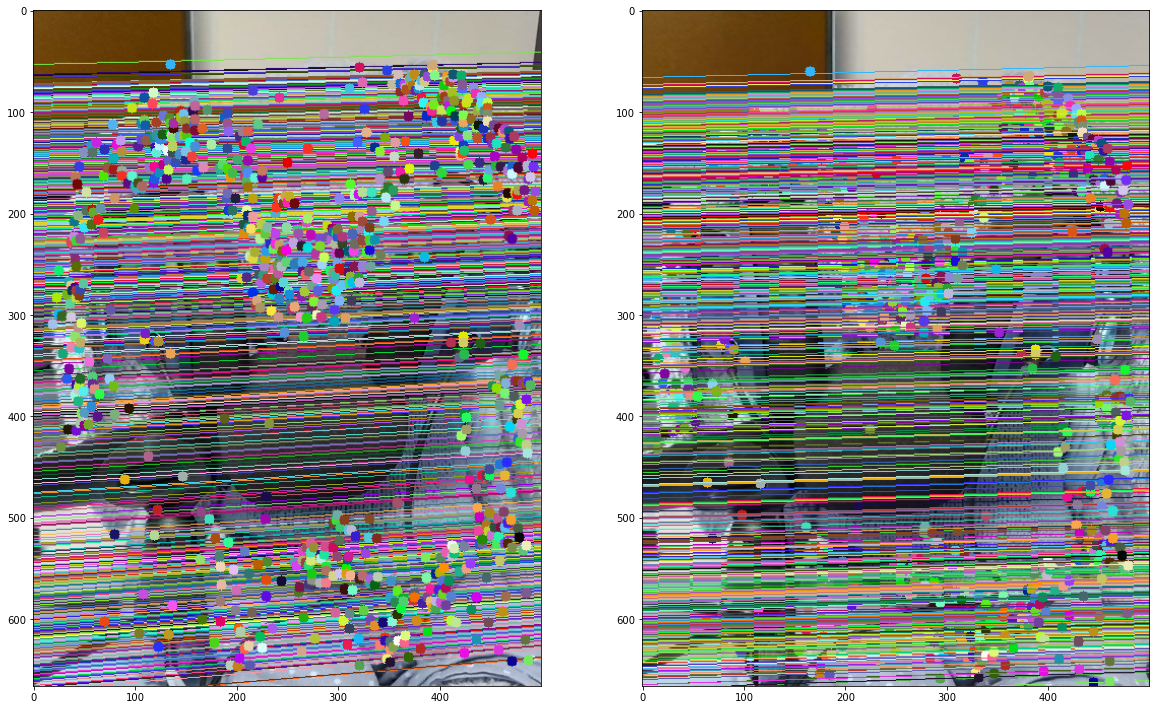

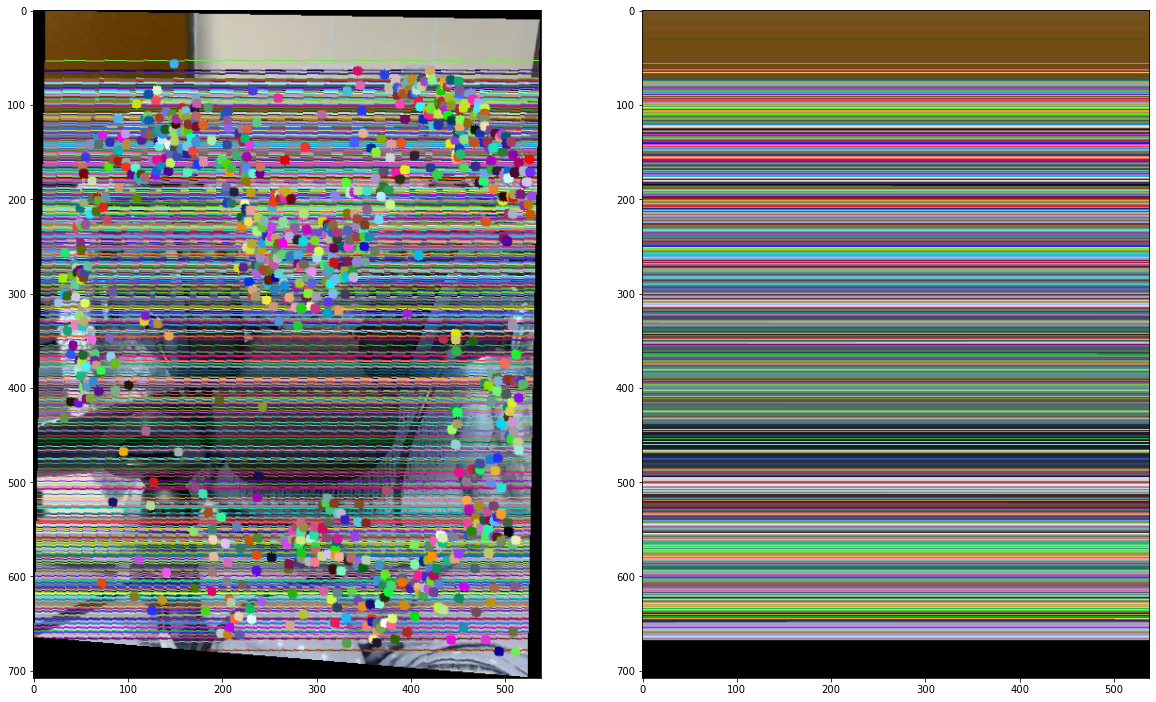

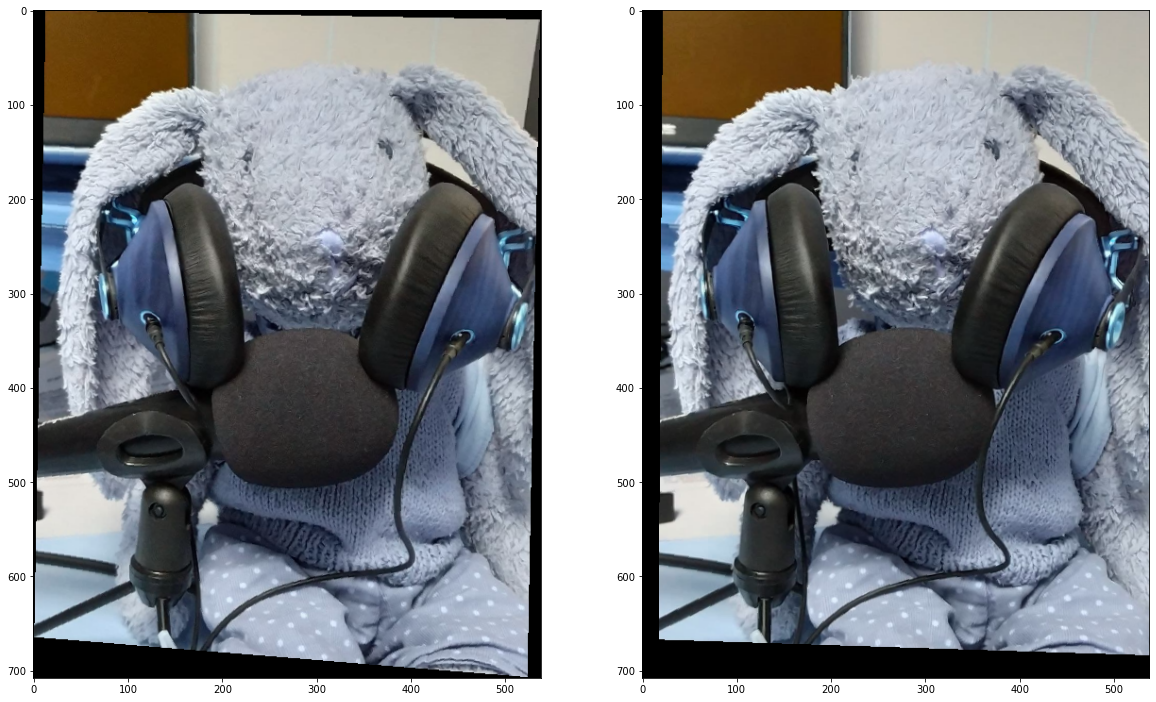

True

In [1]:
import numpy as np
import imutils
import cv2
from matplotlib import pyplot as plt
from scipy.linalg import null_space
import math

ratio = 0.75

def detectAndDescribe(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        descriptor = cv2.xfeatures2d.SIFT_create()
        (kps, features) = descriptor.detectAndCompute(image, None)
        kps = np.float32([kp.pt for kp in kps])
        return (kps, features)
    
def matchKeypoints(kps1, kps2, features1, features2, ratio):
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(features1, features2, 2)
        pts1_ = []
        pts2_ = []
        for m in rawMatches:
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                pts1_.append(m[0].trainIdx)
                pts2_.append(m[0].queryIdx)
        pts1 = np.float32([kps1[i] for i in pts2_])
        pts2 = np.float32([kps2[i] for i in pts1_])
        return (pts1, pts2)
    
def get_fundamental(pts1, pts2):
    X = []
    for i in range(7):
        vec = np.matmul([[pts1[i][0]], [pts1[i][1]], [1]],
                        [[pts2[i][0], pts2[i][1], 1]]).flatten()
        X.append(list(vec))
    F = null_space(X)
    F = F.T
    F1 = F[0]
    F1 = F1.reshape((3, 3))
    F1 /= F1[2][2]
    F2 = F[1]
    F2 = F2.reshape((3, 3))
    F2 /= F2[2][2]
    answer = []
    if np.linalg.matrix_rank(F1) == 2:
        answer.append(F1)
    if np.linalg.matrix_rank(F2) == 2:
        answer.append(F2)
    if len(answer) > 0:
        return answer
    if np.linalg.matrix_rank(F1) < 2:
        return []
    if np.linalg.matrix_rank(F2) < 2:
        return []

    c1 = np.matmul(F2, np.linalg.inv(F1))
    c2 = np.matmul(F1, np.linalg.inv(F2))
    coeff = [np.linalg.det(F1),
             np.linalg.det(F1) * np.trace(c1),
             np.linalg.det(F2) * np.trace(c2),
             np.linalg.det(F2)]
    gammas = np.roots(coeff)
    gamma = [g for g in gammas if np.isreal(g)]
    answer = [(np.real(g) * F1 + F2) for g in gamma]
    answer = [a/a[2][2] for a in answer]
    return answer

def mod(x1, x2):
    return ((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2 + (x1[2] - x2[2])**2)**0.5

def E(F, pts1, pts2, epsilon=10, show=0):
    result = 0
    F /= F[2][2]
    M = np.zeros((len(pts1)), np.int)
    for i in range(len(pts1)):
        c = np.matmul([pts1[i][0], pts1[i][1], 1], F)
        a = np.matmul(c, [[pts2[i][0]], [pts2[i][1]], [1]])[0]
        
        b = (c[0]**2 + c[1]**2)**0.5
        inc = int(abs(a / b) <= epsilon)
        if show == 1:
            print(a / b)
        result += inc
        M[i] = inc
    return result, M

def pick_random_7(pts1, pts2):
    rand_perm = np.random.permutation(len(pts1))
    pts1_ = []
    pts2_ = []
    for i in range(7):
        pts1_.append(pts1[rand_perm[i]])
        pts2_.append(pts2[rand_perm[i]])
    return pts1_, pts2_

def RANSAC(pts1, pts2, epsilon=10):
    F_best = np.zeros((3, 3), np.float32)
    E_best = -1
    M_best = np.zeros((len(pts1)), np.int)
    iterations = 1000
    while iterations > 0:
        pts1_, pts2_ = pick_random_7(pts1, pts2)
        F_cur = get_fundamental(pts1_, pts2_)
        if len(F_cur) > 0:
            for F_c in F_cur:
                E_cur, M_cur = E(F_c, pts1, pts2, epsilon)
                if E_cur > E_best:
                    E_best = E_cur
                    F_best = F_c
                    M_best = M_cur
        iterations -= 1
    return F_best, M_best
    
def draw(img, pts):
    _, c, _ = img.shape
    for pt in pts:
        color = tuple(np.random.randint(0, 255, 3).tolist())
        img = cv2.circle(img, tuple(pt), 5, color, -1)
    return img
    
def drawlines(image1, image2, lines, pts1, pts2):
    _, c, _ = image1.shape
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1] ])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1] ])
        image1 = cv2.circle(image1, tuple(pt1), 5, color, -1)
        image2 = cv2.circle(image2, tuple(pt2), 5, color, -1)
        image1 = cv2.line(image1, (x0, y0), (x1, y1), color, 1)
    return image1

def get_corners(h, w, R):
    corners_bef = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
    corners_aft = cv2.perspectiveTransform(corners_bef, R)
    xmin = math.floor(corners_aft[:, 0, 0].min())
    ymin = math.floor(corners_aft[:, 0, 1].min())
    xmax = math.ceil(corners_aft[:, 0, 0].max())
    ymax = math.ceil(corners_aft[:, 0, 1].max())
    return -xmin, -ymin, math.ceil(xmax - xmin), math.ceil(ymax - ymin)

def panorama(H, img1, h, w):
    img = np.zeros([h, w, 3], np.uint8)
    h_, w_, _ = img1.shape
    H_ = np.linalg.inv(H)
    for y in range(h):
        for x in range(w):
            vec = H_.dot([x, y, 1])
            vec /= vec[2]
            y_new = vec[1]
            x_new = vec[0]
            if y_new >= 0 and y_new < h_ - 1 and x_new >= 0 and x_new < w_ - 1:
                y0 = int(y_new)
                y1 = int(y_new + 0.5)
                x0 = int(x_new)
                x1 = int(x_new + 0.5)
                a0 = a1 = a2 = a3 = 0.25
                if y1 == y0:
                    a0 = 0.5
                    a1 = 0.5
                    a2 = 0
                    a3 = 0
                if x1 == x0:
                    a0 += a1
                    a1 = 0
                    a2 += a3
                    a3 = 0
                if img[y][x][0] == 0 and img[y][x][1] == 0 and img[y][x][2] == 0:
                    img[y][x] = a0 * img1[y0][x0] + a1 * img1[y0][x1] + a2 * img1[y1][x0] + a3 * img1[y1][x1]
                else:
                    img[y][x] = (img[y][x] + a0 * img1[y0][x0] + a1 * img1[y0][x1] + a2 * img1[y1][x0] + a3 * img1[y1][x1]) / 2
                
    return img

nameA = "5"
nameB = "6"
sufix = ".jpg"

imageA = cv2.imread(nameA + sufix)
imageB = cv2.imread(nameB + sufix)

imageA = imutils.resize(imageA, width=500)
imageB = imutils.resize(imageB, width=500)
h, w, _ = imageA.shape

imageA_ = imageA.copy()
imageB_ = imageB.copy()

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imageA)
plt.subplot(122), plt.imshow(imageB)
plt.show()

(kpsA, featuresA) = detectAndDescribe(imageA)
(kpsB, featuresB) = detectAndDescribe(imageB)

(ptsA, ptsB) = matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio)
ptsA = np.int32(ptsA)
ptsB = np.int32(ptsB)

###############################################################

# print("OpenCV results")

# F, mask = cv2.findFundamentalMat(ptsA, ptsB, cv2.FM_LMEDS)
# ptsA_ = ptsA[mask.ravel()==1]
# ptsB_ = ptsB[mask.ravel()==1]

# e1 = null_space(F).T[0]
# e1 /= e1[2]
# e2 = null_space(F.T).T[0]
# e2 /= e2[2]

# lines1 = cv2.computeCorrespondEpilines(ptsB_.reshape(-1, 1, 2), 2, F)
# lines1 = lines1.reshape(-1, 3)
# imageA1 = drawlines(imageA.copy(), imageB.copy(), lines1, ptsA_, ptsB_)

# lines2 = cv2.computeCorrespondEpilines(ptsA_.reshape(-1, 1, 2), 1, F)
# lines2 = lines2.reshape(-1, 3)
# imageA2 = drawlines(imageB.copy(), imageA.copy(), lines2, ptsB_, ptsA_)

# plt.figure(figsize=(20, 20))
# plt.subplot(121), plt.imshow(imageA1)
# plt.subplot(122), plt.imshow(imageA2)
# plt.show()
# cv2.imwrite("res_cv_" + nameA + ".jpg", imageA1) 
# cv2.imwrite("res_cv_" + nameB + ".jpg", imageA2)

###############################################################

print("Our results")

F, M = RANSAC(ptsB, ptsA, 3)
F /= F[2][2]
ptsA_ = ptsA[M==1]
ptsB_ = ptsB[M==1]

e1 = null_space(F).T[0]
e1 /= e1[2]
e2 = null_space(F.T).T[0]
e2 /= e2[2]

lines1 = cv2.computeCorrespondEpilines(ptsB_.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
imageA1 = drawlines(imageA, imageB, lines1, ptsA_, ptsB_)

lines2 = cv2.computeCorrespondEpilines(ptsA_.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
imageA2 = drawlines(imageB, imageA, lines2, ptsB_, ptsA_)

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imageA1)
plt.subplot(122), plt.imshow(imageA2)
plt.show()
cv2.imwrite("res_" + nameA + ".jpg", imageA1)
cv2.imwrite("res_" + nameB + ".jpg", imageA2)

###############################################################

k = np.zeros(3)
k[2] = 1

R = np.zeros((3, 3))
R[2] = k

rx = np.cross(k, np.cross(e1, k))
rx /= np.linalg.norm(rx)
R[0] = rx

ry = np.cross(k, e1)
ry /= np.linalg.norm(ry)
R[1] = ry

G = np.zeros((3, 3))
G[0][0] = 1
G[1][1] = 1
G[2][2] = 1
G[2][0] = - 1 / (np.dot(R, e1)[0])

Rl = np.dot(G, R)

Ex = np.array([[0, -e2[2], e2[1]],
               [e2[2], 0, -e2[0]],
               [-e2[1], e2[0], 0]])

Rr_ = np.dot(np.dot(Rl, Ex), F.T)

Rr = Rr_
Rr[0] = np.cross(Rr[1], Rr[2])
# Rr[0] /= np.linalg.norm(Rr[2])

###############################################################

c1, c2, w1, h1 = get_corners(h, w, Rl)
translate = np.eye(3)
translate[0, 2] = c1
translate[1, 2] = c2
Rl_t = np.dot(translate, Rl)
imageB1 = panorama(Rl_t, imageA1, h1, w1)

Rr_t = np.dot(translate, Rr)
imageB2 = panorama(Rr_t, imageA2, h1, w1)

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imageB1)
plt.subplot(122), plt.imshow(imageB2)
plt.show()
cv2.imwrite("res_homographed_" + nameA + ".jpg", imageB1)
cv2.imwrite("res_homographed_" + nameB + ".jpg", imageB2)

###############################################################

A = []
B = []
for i in range(len(ptsA_)):
    l = np.dot(Rl, [ptsA_[i][0], ptsA_[i][1], 1])
    B.append(l[0] / l[2])
    r = np.dot(Rr, [ptsB_[i][0], ptsB_[i][1], 1])
    r /= r[2]
    A.append(r)

a, b, c = np.linalg.lstsq(A, B, rcond=None)[0]

E = np.eye(3)
E[0][0] = a
E[0][1] = b
E[0][2] = c
Rr = np.dot(E, Rr)

###############################################################

c1, c2, w1, h1 = get_corners(h, w, Rl)
translate = np.eye(3)
translate[0, 2] = c1
translate[1, 2] = c2
Rl_t = np.dot(translate, Rl)
imageB1 = panorama(Rl_t, imageA_, h1, w1)

Rr_t = np.dot(translate, Rr)
imageB2 = panorama(Rr_t, imageB_, h1, w1)

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(imageB1)
plt.subplot(122), plt.imshow(imageB2)
plt.show()
cv2.imwrite("res_homographed_" + nameA + ".jpg", imageB1)
cv2.imwrite("res_homographed_" + nameB + ".jpg", imageB2)

###############################################################